In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

     |████████████████████████████████| 3.7MB 5.8MB/s 


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split
import os
import IPython.display as display
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
from tensorflow_examples.models.pix2pix import pix2pix

In [ ]:
creating_model = True
processing_data = False

# Load and process data

In [ ]:
with zipfile.ZipFile("./drive/My Drive/Colab Notebooks/dataset_mask_output.zip", 'r') as zip_ref:
  zip_ref.extractall(".")
print(len(os.listdir("dataset_mask_output/x")))
source = [str(i) + ".jpg" for i in range(len(os.listdir("dataset_mask_output/x/")))]
pictures_df = pd.DataFrame(source)

2975


In [ ]:
if processing_data:
  data = pictures_df.sample(frac=1).reset_index(drop=True)
  training_data, validation_data = train_test_split(data, test_size=0.1)
  training_data = training_data.sample(frac=1).reset_index(drop=True)
  validation_data = validation_data.sample(frac=1).reset_index(drop=True)
  training_data.to_csv("./drive/My Drive/Colab Notebooks/segmentation_training.csv", index=False)
  validation_data.to_csv("./drive/My Drive/Colab Notebooks/segmentation_validation.csv", index=False)
else:
  training_data = pd.read_csv("./drive/My Drive/Colab Notebooks/segmentation_training.csv")
  validation_data = pd.read_csv("./drive/My Drive/Colab Notebooks/segmentation_validation.csv")
print(len(training_data))
print(len(validation_data))

2677
298


In [ ]:
print(training_data)
print(validation_data)

             0
0     1910.jpg
1     1563.jpg
2     2897.jpg
3     1344.jpg
4      212.jpg
...        ...
2672  1829.jpg
2673   531.jpg
2674  1621.jpg
2675    48.jpg
2676  1874.jpg

[2677 rows x 1 columns]
            0
0    2377.jpg
1    1975.jpg
2    1643.jpg
3     695.jpg
4     958.jpg
..        ...
293  1858.jpg
294  1667.jpg
295   318.jpg
296  1410.jpg
297  2763.jpg

[298 rows x 1 columns]


In [ ]:
@tf.function
def load_image(dir_prefix, row):
  img = matplotlib.image.imread(dir_prefix + row[0])
  return tf.convert_to_tensor(img, dtype=tf.float32) / 255.0

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch_indices = [self.indices[k] for k in index]
        X, Y = self.__get_data(batch_indices)
        return X, Y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle:
            np.random.shuffle(self.index)

    def __get_data(self, batch_indices):
        batch = self.df.iloc[batch_indices,:]
        batch["x"] = batch.apply(lambda row: load_image("dataset_mask_output/x/", row), axis=1)
        batch["y"] = batch.apply(lambda row: load_image("dataset_mask_output/y/", row), axis=1)
        X = tf.convert_to_tensor(batch["x"].tolist())
        Y = tf.convert_to_tensor(batch["y"].tolist())
        return X, Y


In [ ]:
train_dataset = DataGenerator(training_data)
val_dataset = DataGenerator(validation_data)

# Create Model

**Create model**

In [ ]:
OUTPUT_CHANNELS = 3

base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 112x112
    'block_3_expand_relu',   # 56x56
    'block_6_expand_relu',   # 28x28
    'block_13_expand_relu',  # 14x14
    'block_16_project',      # 7x7
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

up_stack = [
    pix2pix.upsample(896, 3),  # 7x7 -> 14x14
    pix2pix.upsample(448, 3),  # 14x14 -> 28x28
    pix2pix.upsample(224, 3),  # 28x28 -> 56x56
    pix2pix.upsample(112, 3),   # 56x56 -> 112x112
]

def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same') #, activation=tf.keras.activations.sigmoid)  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

9412608/9406464 [==============================] - 0s 0us/step


**Create or Load model**

In [ ]:
if creating_model:
  model = unet_model(OUTPUT_CHANNELS)
  model.compile(optimizer='adam',
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=['accuracy'])
else:
  model = tf.keras.models.load_model("./drive/My Drive/Colab Notebooks/seg.hdf5")
tf.keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       [(None, 112, 112, 96 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 14, 14, 896)  2584064     functional_1[0][4]               
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 14, 14, 1472) 0           sequential[0][0]                 
                                                                 functional_1[0][3]    

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    
show_predictions()

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

# Training

In [ ]:
model.evaluate(train_dataset)

In [ ]:
tf.config.run_functions_eagerly(True)
model.fit(train_dataset, validation_data=val_dataset, epochs=30)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even th

Epoch 1/30
83/83 [==============================] - 39s 471ms/step - loss: 0.0579 - accuracy: 0.3575 - val_loss: 0.0240 - val_accuracy: 0.3341
Epoch 2/30
83/83 [==============================] - 39s 465ms/step - loss: 0.0118 - accuracy: 0.3544 - val_loss: 0.0114 - val_accuracy: 0.2506
Epoch 3/30
83/83 [==============================] - 38s 460ms/step - loss: 0.0075 - accuracy: 0.3575 - val_loss: 0.0077 - val_accuracy: 0.2831
Epoch 4/30
83/83 [==============================] - 38s 457ms/step - loss: 0.0057 - accuracy: 0.3710 - val_loss: 0.0062 - val_accuracy: 0.3665
Epoch 5/30
83/83 [==============================] - 38s 460ms/step - loss: 0.0048 - accuracy: 0.3781 - val_loss: 0.0052 - val_accuracy: 0.4300
Epoch 6/30
83/83 [==============================] - 38s 463ms/step - loss: 0.0042 - accuracy: 0.3798 - val_loss: 0.0048 - val_accuracy: 0.3618
Epoch 7/30
83/83 [==============================] - 38s 461ms/step - loss: 0.0037 - accuracy: 0.3786 - val_loss: 0.0042 - val_accuracy: 0.3724

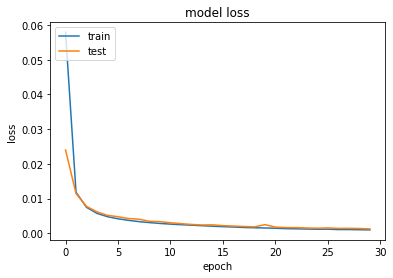

In [ ]:
# summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save("./drive/My Drive/Colab Notebooks/seg.hdf5")  

# Network validation

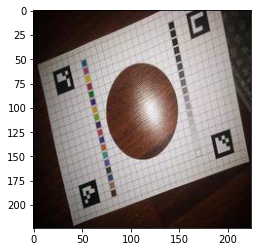

In [ ]:
plt.imshow(matplotlib.image.imread('dataset_mask_output/x/2377.jpg'))


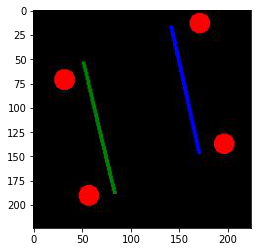

In [ ]:
plt.imshow(matplotlib.image.imread('dataset_mask_output/y/2377.jpg'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


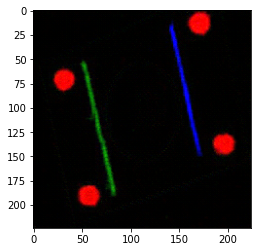

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask
  
img = load_image('dataset_mask_output/x/', ["2377.jpg"])
mask = model(tf.convert_to_tensor([img]))
plt.imshow(mask[0,:,:,:])

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('./drive/My Drive/Colab Notebooks/model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmp0g3gpdp5/assets
